In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")

In [7]:
device_df=pd.read_csv('device.csv')
#http file did not have column headers so i added them
http_headers = ['id', 'date', 'time', 'user', 'pc', 'url', 'content', 'bytes_sent', 'bytes_received']
http_df = pd.read_csv('http.csv', header=None, names=http_headers)
logon_df=pd.read_csv('logon.csv')

In [8]:
#counting number of activities done by a particular user on the specific date
logon_agg = logon_df.groupby(['user', 'date']).agg({
    'activity': 'count'     
}).reset_index().rename(columns={
    'activity': 'logon_count'
})

In [9]:
#count the number of sites visited,bytes recieved/send by a user on the date
http_agg = http_df.groupby(['user', 'date']).agg({
    'url': 'count',         
    'bytes_sent': 'sum',  
    'bytes_received': 'sum' 
}).reset_index().rename(columns={
    'url': 'http_requests',
    'bytes_sent': 'http_bytes_sent',
    'bytes_received': 'http_bytes_received'
})

In [10]:
#counting number of activities done by a particular user on the specific date
device_agg = device_df.groupby(['user', 'date']).agg({
    'activity': 'count'
}).reset_index().rename(columns={'activity': 'device_activity_count'})

In [13]:
#merged all the data in a single dataframe:merged_df
dfs = [logon_agg, http_agg, device_agg]
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['user', 'date'], how='outer'), dfs)
merged_df.fillna(0, inplace=True)

In [14]:
#converted date object to year,mont,day,weekday,houe,minute,is_working_day
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month
merged_df['day'] = merged_df['date'].dt.day
merged_df['weekday'] = merged_df['date'].dt.weekday  # Monday=0, Sunday=6
merged_df['hour'] = merged_df['date'].dt.hour
merged_df['minute'] = merged_df['date'].dt.minute
merged_df['is_working_day'] = merged_df['weekday'].apply(lambda x: 1 if x < 5 else 0)

In [15]:
#User-Specific Behavioral Patterns: to check if the user deviated from his usual pattern
user_baseline = merged_df.groupby('user').agg({
    'logon_count': ['mean', 'std'],
    'http_requests': ['mean', 'std'],
    'device_activity_count': ['mean', 'std']
})
user_baseline.columns = ['_'.join(col) for col in user_baseline.columns]
user_baseline.reset_index(inplace=True)
merged_df = merged_df.merge(user_baseline, on='user', how='left')
merged_df['logon_spike'] = (merged_df['logon_count'] - merged_df['logon_count_mean']) / merged_df['logon_count_std']
merged_df['http_spike'] = (merged_df['http_requests'] - merged_df['http_requests_mean']) / merged_df['http_requests_std']
merged_df['device_spike'] = (merged_df['device_activity_count'] - merged_df['device_activity_count_mean']) / merged_df['device_activity_count_std']

In [16]:
#Detect unusual usage emphasis (if there unusual high activity by a user)
merged_df['device_http_ratio'] = merged_df['device_activity_count'] / (merged_df['http_requests'] + 1)
merged_df['logon_http_ratio'] = merged_df['logon_count'] / (merged_df['http_requests'] + 1)

#Check if the person has unusual activity after work hours
merged_df['week_of_month'] = merged_df['day'].apply(lambda d: (d - 1) // 7 + 1)
merged_df['is_off_hours'] = merged_df['hour'].apply(lambda h: 1 if (h < 7 or h > 19) else 0)

In [17]:
#Detect change over time for a user
merged_df = merged_df.sort_values(['user', 'date'])
merged_df['logon_rolling_3'] = merged_df.groupby('user')['logon_count'].transform(lambda x: x.rolling(3, min_periods=1).mean())
merged_df['logon_delta'] = merged_df['logon_count'] - merged_df['logon_rolling_3']

#Insider behavior might include skipping typical actions
merged_df['http_missing'] = (merged_df['http_requests'] == 0).astype(int)
merged_df['device_missing'] = (merged_df['device_activity_count'] == 0).astype(int)
merged_df['logon_missing'] = (merged_df['logon_count'] == 0).astype(int)

In [18]:
features_to_keep = [
    'logon_count',
    'http_requests',
    'http_bytes_sent',
    'http_bytes_received',
    'device_activity_count',
    
    'logon_spike',
    'http_spike',
    'device_spike',
    
    'device_http_ratio',
    'logon_http_ratio',
    
    'hour',
    'weekday',
    'is_working_day',
    'is_off_hours',
    
    'logon_rolling_3',
    'logon_delta'
]
#Final training data
X = merged_df[features_to_keep].copy()

In [21]:
contamination_vals = [0.01, 0.015, 0.02, 0.025, 0.03]
max_features_vals = [0.5, 0.75, 1.0]

results = []

In [22]:
for c in contamination_vals:
    for mf in max_features_vals:
        model = IsolationForest(
            contamination=c,
            max_features=mf,
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X)
        preds = model.predict(X)
        scores = -model.decision_function(X)  # Inverted: higher = more risky

        # Save to temp DataFrame to get thresholds for risk levels
        temp_df = pd.DataFrame({'risk_score': scores})
        low_thresh = temp_df['risk_score'].quantile(0.75)
        high_thresh = temp_df['risk_score'].quantile(0.95)

        def classify_risk(score):
            if score < low_thresh:
                return 'Low'
            elif score < high_thresh:
                return 'Medium'
            else:
                return 'High'

        risk_levels = temp_df['risk_score'].apply(classify_risk)

        results.append({
            'contamination': c,
            'max_features': mf,
            'score_std': np.std(scores),
            'score_mean': np.mean(scores),
            'anomaly_count': (preds == -1).sum(),
            'high_risk_count': (risk_levels == 'High').sum(),
            'medium_risk_count': (risk_levels == 'Medium').sum()
        })

results_df = pd.DataFrame(results)

In [23]:
best_config = results_df.sort_values(by='score_std', ascending=False).iloc[0]
final_model = IsolationForest(
    contamination=best_config['contamination'],
    max_features=best_config['max_features'],
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X)
merged_df['risk_score'] = -final_model.decision_function(X)
merged_df['anomaly'] = final_model.predict(X)

# Assign Risk Levels
low_thresh = merged_df['risk_score'].quantile(0.75)
high_thresh = merged_df['risk_score'].quantile(0.95)

def classify_risk(score):
    if score < low_thresh:
        return 'Low'
    elif score < high_thresh:
        return 'Medium'
    else:
        return 'High'

merged_df['risk_level'] = merged_df['risk_score'].apply(classify_risk)


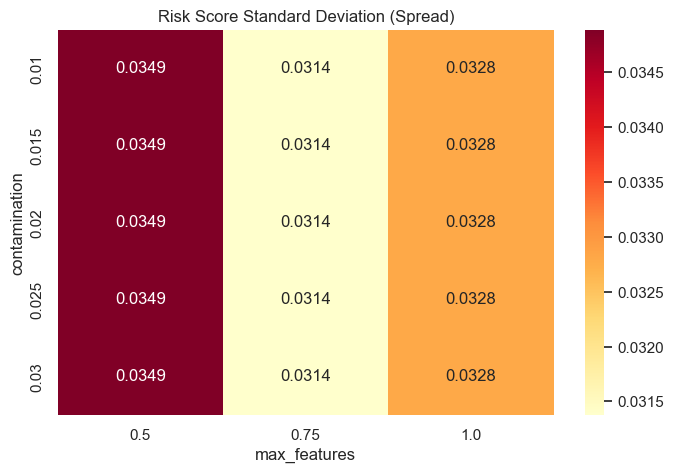

In [24]:
# Heatmap: Risk Score Spread (Standard Deviation)
plt.figure(figsize=(8, 5))
pivot_std = results_df.pivot(index='contamination', columns='max_features', values='score_std')
sns.heatmap(pivot_std, annot=True, cmap='YlOrRd', fmt=".4f")
plt.title('Risk Score Standard Deviation (Spread)')
plt.xlabel('max_features')
plt.ylabel('contamination')
plt.show()

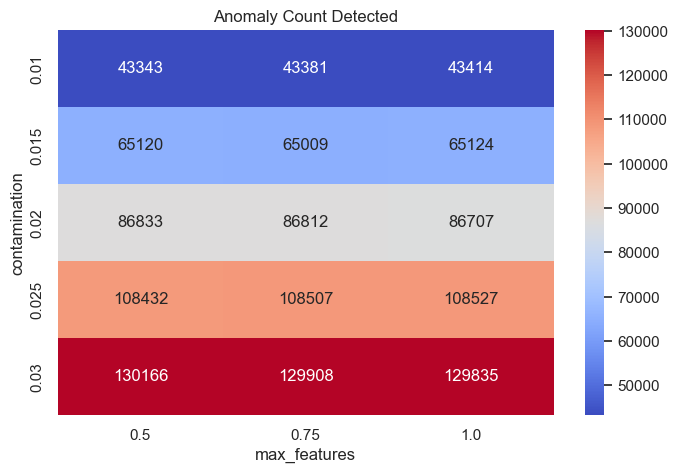

In [25]:
# Heatmap: Anomaly Counts
plt.figure(figsize=(8, 5))
pivot_count = results_df.pivot(index='contamination', columns='max_features', values='anomaly_count')
sns.heatmap(pivot_count, annot=True, cmap='coolwarm', fmt=".0f")
plt.title('Anomaly Count Detected')
plt.xlabel('max_features')
plt.ylabel('contamination')
plt.show()

In [26]:
print("🏆 Best Configuration:")
print(best_config)

print("\n✅ Final Risk Level Counts:")
print(merged_df['risk_level'].value_counts())

print("\n🔍 Top 5 High Risk Records:")
print(merged_df[merged_df['risk_level'] == 'High'][['user', 'date', 'risk_score', 'risk_level']].sort_values(by='risk_score', ascending=False).head())

🏆 Best Configuration:
contamination             0.010000
max_features              0.500000
score_std                 0.034882
score_mean               -0.141162
anomaly_count         43343.000000
high_risk_count      217092.000000
medium_risk_count    870074.000000
Name: 0, dtype: float64

✅ Final Risk Level Counts:
risk_level
Low       3254512
Medium     870074
High       217092
Name: count, dtype: int64

🔍 Top 5 High Risk Records:
                user                date  risk_score risk_level
334534  DTAA/FKR0550 2010-08-09 23:09:40    0.054295       High
493219  DTAA/KAD0059 2010-12-06 23:32:32    0.054295       High
637053  DTAA/NDM0893 2010-02-22 23:31:31    0.054295       High
723511  DTAA/RAH0968 2010-04-05 23:21:24    0.054295       High
479141  DTAA/JSE0020 2010-05-17 23:31:03    0.054295       High


In [ ]:
# Columns to export
export_columns = ['user', 'date'] + features_to_keep + ['risk_score', 'risk_level']

# Ensure all columns exist
final_df = merged_df[export_columns].copy()

# Export to CSV
final_df.to_csv('user_risk_analysis.csv', index=False)

print("✅ File saved as 'user_risk_analysis.csv'")



✅ File saved as 'user_risk_analysis.csv'
